In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [ ]:
!pip install torchinfo

In [ ]:
from medmnist import OCTMNIST
import torchvision.transforms as transforms
import torch
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, roc_curve, auc
import time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# **Dataset Loading and Preprocessing**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = OCTMNIST(split='train', download=True, transform=transform)
val_dataset = OCTMNIST(split='val', download=True, transform=transform)
test_dataset = OCTMNIST(split='test', download=True, transform=transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

100%|██████████| 54.9M/54.9M [00:05<00:00, 9.86MB/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using device: cuda


In [ ]:
datasets = {'Train': train_dataset, 'Validation': val_dataset, 'Test': test_dataset}

def statsData(dataset, name):
    num_samples = len(dataset)
    all_labels = [dataset[i][1].item() for i in range(num_samples)]
    label_counts = Counter(all_labels)

    all_images = torch.stack([dataset[i][0] for i in range(num_samples)]).to(device)

    mean = all_images.mean().item()
    std = all_images.std().item()
    min_pixel = all_images.min().item()
    max_pixel = all_images.max().item()

    print(f"Dataset: {name}")
    print(f"Total Samples: {num_samples}")
    print(f"Image Shape: {all_images.shape[1:]}")
    print(f"Label Distribution: {dict(label_counts)}")
    print(f"Pixel Intensity - Mean: {mean:.4f}, Std: {std:.4f}, Min: {min_pixel}, Max: {max_pixel}\n")

for name, dataset in datasets.items():
    statsData(dataset, name)

Dataset: Train
Total Samples: 97477
Image Shape: torch.Size([1, 28, 28])
Label Distribution: {0: 33484, 3: 46026, 1: 10213, 2: 7754}
Pixel Intensity - Mean: -0.6221, Std: 0.3926, Min: -1.0, Max: 1.0

Dataset: Validation
Total Samples: 10832
Image Shape: torch.Size([1, 28, 28])
Label Distribution: {3: 5114, 0: 3721, 1: 1135, 2: 862}
Pixel Intensity - Mean: -0.6231, Std: 0.3915, Min: -1.0, Max: 1.0

Dataset: Test
Total Samples: 1000
Image Shape: torch.Size([1, 28, 28])
Label Distribution: {3: 250, 2: 250, 0: 250, 1: 250}
Pixel Intensity - Mean: -0.5941, Std: 0.4218, Min: -1.0, Max: 1.0



<ipython-input-6-e1820bbb3e68>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="viridis")


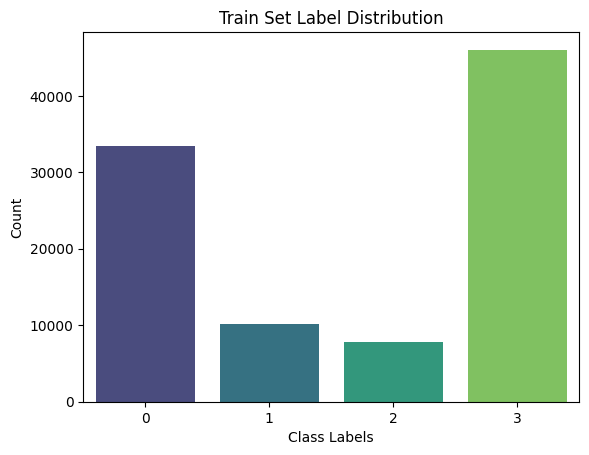

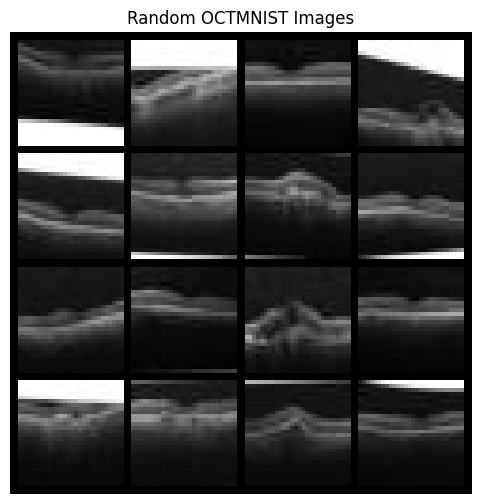

In [ ]:
def plotDist(dataset, title):
    labels = [dataset[i][1].item() for i in range(len(dataset))]
    sns.countplot(x=labels, palette="viridis")
    plt.title(title)
    plt.xlabel("Class Labels")
    plt.ylabel("Count")
    plt.show()

plotDist(train_dataset, "Train Set Label Distribution")

def randImg(dataset, num_images=16):
    indices = np.random.choice(len(dataset), num_images, replace=False)
    images = torch.stack([dataset[i][0] for i in indices])  # Shape: (num_images, 1, 28, 28)

    grid_img = make_grid(images, nrow=4, padding=2, normalize=True)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid_img.permute(1, 2, 0), cmap="gray")
    plt.title("Random OCTMNIST Images")
    plt.axis("off")
    plt.show()

randImg(train_dataset)

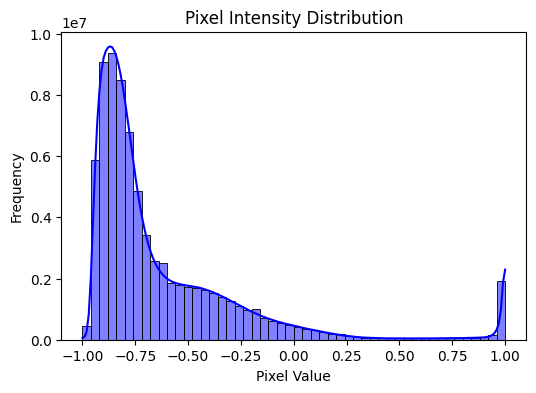

In [ ]:
def pxlDist(dataset):
    all_images = torch.cat([dataset[i][0].flatten() for i in range(len(dataset))])

    plt.figure(figsize=(6, 4))
    sns.histplot(all_images.numpy(), bins=50, kde=True, color="blue")
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

pxlDist(train_dataset)

In [ ]:
# oversampling

labels = [train_dataset[i][1].item() for i in range(len(train_dataset))]
class_counts = Counter(labels)
total_samples = sum(class_counts.values())
class_weights = {label: total_samples/class_counts[label] for label in class_counts}
weights = [class_weights[label] for label in labels]
print(f"Computed Class Weights: {class_weights}")

sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
labels = np.array([train_dataset[i][1].item() for i in range(len(train_dataset))]).reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)

# one-hot encoding
one_hot_labels = encoder.fit_transform(labels)

print(f"One-Hot Encoded Labels Shape: {one_hot_labels.shape}")
print(f"Example Encoding: {one_hot_labels[:5]}")

class oneHotData(Dataset):
    def __init__(self, dataset, one_hot_labels):
        self.dataset = dataset
        self.one_hot_labels = one_hot_labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return img, torch.tensor(self.one_hot_labels[idx], dtype=torch.float32)

train_dataset = oneHotData(train_dataset, one_hot_labels)

Computed Class Weights: {0: 2.911151594791542, 3: 2.1178681614739494, 1: 9.544404190737296, 2: 12.571189063709053}
One-Hot Encoded Labels Shape: (97477, 4)
Example Encoding: [[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [ ]:
images = np.array([train_dataset[i][0].numpy().flatten() for i in range(len(train_dataset))])
labels = np.array([train_dataset[i][1].numpy() for i in range(len(train_dataset))])

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

class cusData(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = cusData(X_train, y_train)
val_dataset = cusData(X_val, y_val)
test_dataset = cusData(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# **Base Model**

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = CNNModel().to(device)
summary(model, input_size=(32, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [32, 4]                   --
├─Conv2d: 1-1                            [32, 32, 28, 28]          320
├─MaxPool2d: 1-2                         [32, 32, 14, 14]          --
├─Conv2d: 1-3                            [32, 64, 14, 14]          18,496
├─MaxPool2d: 1-4                         [32, 64, 7, 7]            --
├─Linear: 1-5                            [32, 128]                 401,536
├─Dropout: 1-6                           [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─Dropout: 1-8                           [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
Total params: 428,868
Trainable params: 428,868
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 137.16
Input size (MB): 0.10
Forward/backward pass size (MB): 9.68
Params size (MB): 1.72
Estimated Tota

# **Base Model with CrossEntropyLoss**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 30
batch_size = 64

model.train()
start_time = time.time()

train_accuracies = []
val_accuracies = []
test_accuracies = []
train_losses = []
val_losses = []
test_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    correct, total = 0, 0
    for inputs, labels in train_loader:
        inputs = inputs.view(inputs.size(0), 1, 28, 28).to(device)
        labels = torch.argmax(labels, dim=1).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)


    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:

            val_inputs = val_inputs.view(val_inputs.size(0), 1, 28, 28).to(device)
            val_labels = torch.argmax(val_labels, dim=1).to(device)

            val_outputs = model(val_inputs)
            loss = loss_function(val_outputs, val_labels)
            val_loss += loss.item()
            _, preds = torch.max(val_outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())
            correct += (preds == val_labels).sum().item()
            total += val_labels.size(0)


    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in: {training_time:.2f} seconds")


Epoch [1/30], Train Loss: 0.7500, Train Accuracy: 0.7283
Val Loss: 0.5197, Val Accuracy: 0.8190
Precision: 0.6036, Recall: 0.6040, F1-Score: 0.5974
Epoch [2/30], Train Loss: 0.4733, Train Accuracy: 0.8343
Val Loss: 0.4229, Val Accuracy: 0.8509
Precision: 0.7426, Recall: 0.6761, F1-Score: 0.6795
Epoch [3/30], Train Loss: 0.4096, Train Accuracy: 0.8551
Val Loss: 0.4059, Val Accuracy: 0.8558
Precision: 0.7629, Recall: 0.6877, F1-Score: 0.7084
Epoch [4/30], Train Loss: 0.3723, Train Accuracy: 0.8691
Val Loss: 0.3941, Val Accuracy: 0.8647
Precision: 0.8035, Recall: 0.6776, F1-Score: 0.7013
Epoch [5/30], Train Loss: 0.3442, Train Accuracy: 0.8769
Val Loss: 0.3923, Val Accuracy: 0.8651
Precision: 0.7986, Recall: 0.6952, F1-Score: 0.7195
Epoch [6/30], Train Loss: 0.3220, Train Accuracy: 0.8855
Val Loss: 0.3508, Val Accuracy: 0.8797
Precision: 0.8267, Recall: 0.7158, F1-Score: 0.7318
Epoch [7/30], Train Loss: 0.3009, Train Accuracy: 0.8938
Val Loss: 0.3427, Val Accuracy: 0.8817
Precision: 0.807

In [ ]:
model.eval()

test_preds = []
test_labels_list = []

with torch.no_grad():
    for test_inputs, test_labels_batch in test_loader:
        test_inputs = test_inputs.view(test_inputs.size(0), 1, 28, 28).to(device)

        test_outputs = model(test_inputs)
        _, preds = torch.max(test_outputs, 1)
        test_preds.extend(preds.cpu().numpy())

        if len(test_labels_batch.shape) > 1:
            test_labels_batch = test_labels_batch.argmax(dim=1)

        test_labels_list.extend(test_labels_batch.cpu().numpy())

test_accuracy = accuracy_score(test_labels_list, test_preds)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels_list, test_preds, average='macro')

print(f"Base Model with CrossEntropyLoss")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1-Score: {test_f1:.4f}")


Base Model with CrossEntropyLoss
Test Accuracy: 0.8840
Test Precision: 0.8145, Test Recall: 0.8012, Test F1-Score: 0.8058


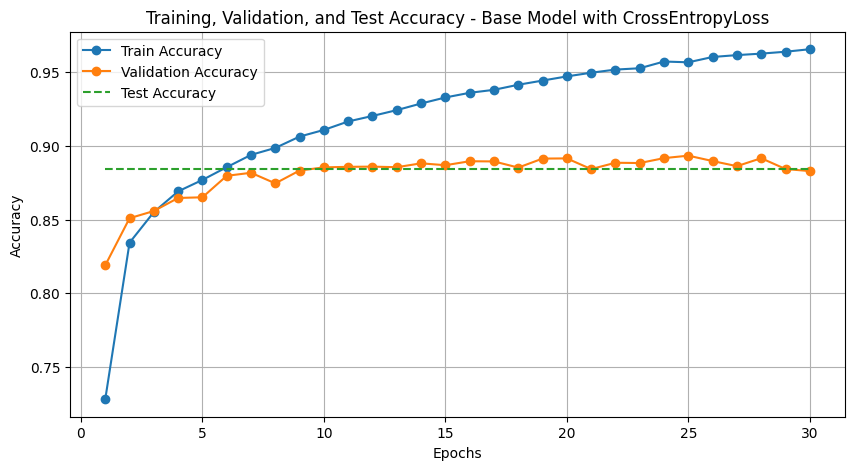

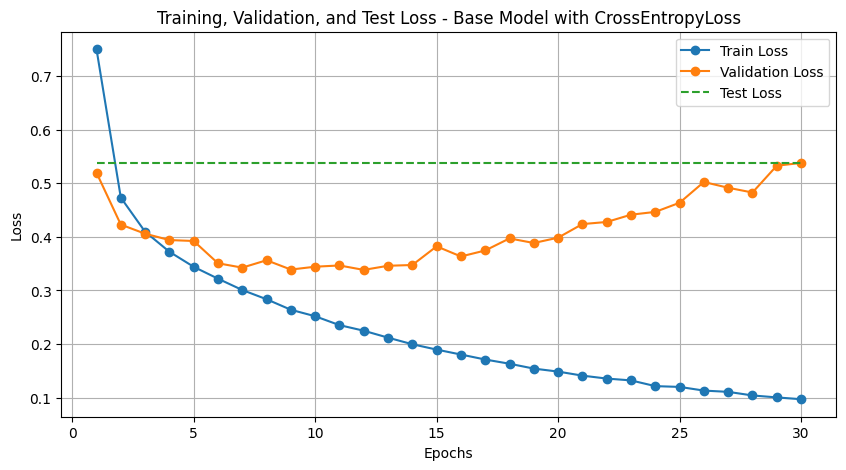

In [ ]:
test_accuracies = [test_accuracy] * epochs
test_loss = val_losses[-1]
test_losses = [test_loss] * epochs

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', linestyle="dashed")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy - Base Model with CrossEntropyLoss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle="dashed")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss - Base Model with CrossEntropyLoss')
plt.legend()
plt.grid(True)
plt.show()

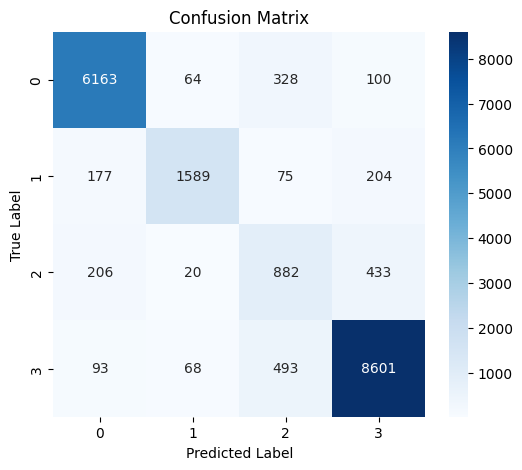

In [ ]:
cm = confusion_matrix(test_labels_list, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **Base Model with MSELoss**

In [ ]:
# New Loss Function used MSELoss
loss_function_2 = nn.MSELoss()
model_2 = CNNModel().to(device)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)

train_accuracies_2 = []
val_accuracies_2 = []
test_accuracies_2 = []
train_losses_2 = []
val_losses_2 = []
test_losses_2 = []

for epoch in range(epochs):
    running_loss = 0.0
    correct, total = 0, 0
    for inputs, labels in train_loader:
        inputs = inputs.view(inputs.size(0), 1, 28, 28).to(device)
        labels = torch.argmax(labels, dim=1).to(device)

        optimizer_2.zero_grad()
        outputs = model_2(inputs)
        loss = loss_function_2(outputs, F.one_hot(labels, num_classes=4).float())
        loss.backward()
        optimizer_2.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_accuracies_2.append(train_accuracy)
    epoch_loss = running_loss / len(train_loader)
    train_losses_2.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    model_2.eval()
    val_loss = 0.0
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.view(val_inputs.size(0), 1, 28, 28).to(device)
            val_labels = torch.argmax(val_labels, dim=1).to(device)

            val_outputs = model_2(val_inputs)
            loss = loss_function_2(val_outputs, F.one_hot(val_labels, num_classes=4).float())  # For MSELoss
            val_loss += loss.item()
            _, preds = torch.max(val_outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())
            correct += (preds == val_labels).sum().item()
            total += val_labels.size(0)

    val_accuracy = correct / total
    val_accuracies_2.append(val_accuracy)
    val_loss /= len(val_loader)
    val_losses_2.append(val_loss)

    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Epoch [1/30], Train Loss: 0.0946, Train Accuracy: 0.7510
Val Loss: 0.0711, Val Accuracy: 0.8188
Precision: 0.5925, Recall: 0.6180, F1-Score: 0.6034
Epoch [2/30], Train Loss: 0.0625, Train Accuracy: 0.8339
Val Loss: 0.0575, Val Accuracy: 0.8483
Precision: 0.7536, Recall: 0.6461, F1-Score: 0.6444
Epoch [3/30], Train Loss: 0.0553, Train Accuracy: 0.8529
Val Loss: 0.0527, Val Accuracy: 0.8610
Precision: 0.7836, Recall: 0.6738, F1-Score: 0.6781
Epoch [4/30], Train Loss: 0.0516, Train Accuracy: 0.8643
Val Loss: 0.0513, Val Accuracy: 0.8659
Precision: 0.7872, Recall: 0.6970, F1-Score: 0.7071
Epoch [5/30], Train Loss: 0.0488, Train Accuracy: 0.8733
Val Loss: 0.0499, Val Accuracy: 0.8676
Precision: 0.7962, Recall: 0.7029, F1-Score: 0.6984
Epoch [6/30], Train Loss: 0.0460, Train Accuracy: 0.8803
Val Loss: 0.0520, Val Accuracy: 0.8670
Precision: 0.7895, Recall: 0.7207, F1-Score: 0.7435
Epoch [7/30], Train Loss: 0.0439, Train Accuracy: 0.8865
Val Loss: 0.0473, Val Accuracy: 0.8770
Precision: 0.822

In [ ]:
test_preds_2 = []
test_labels_list_2 = []

with torch.no_grad():
    for test_inputs, test_labels_batch in test_loader:
        test_inputs = test_inputs.view(test_inputs.size(0), 1, 28, 28).to(device)

        test_outputs = model_2(test_inputs)
        _, preds = torch.max(test_outputs, 1)
        test_preds_2.extend(preds.cpu().numpy())

        if len(test_labels_batch.shape) > 1:
            test_labels_batch = test_labels_batch.argmax(dim=1)

        test_labels_list_2.extend(test_labels_batch.cpu().numpy())

test_accuracy_2 = accuracy_score(test_labels_list_2, test_preds_2)
test_precision_2, test_recall_2, test_f1_2, _ = precision_recall_fscore_support(test_labels_list_2, test_preds_2, average='macro')

print(f"Base Model with MSELoss")
print(f"Test Accuracy: {test_accuracy_2:.4f}")
print(f"Test Precision: {test_precision_2:.4f}, Test Recall: {test_recall_2:.4f}, Test F1-Score: {test_f1_2:.4f}")

Base Model with MSELoss
Test Accuracy: 0.8888
Test Precision: 0.8171, Test Recall: 0.7932, Test F1-Score: 0.8042


# **Comparision crossEntropyLoss vs MSELoss**

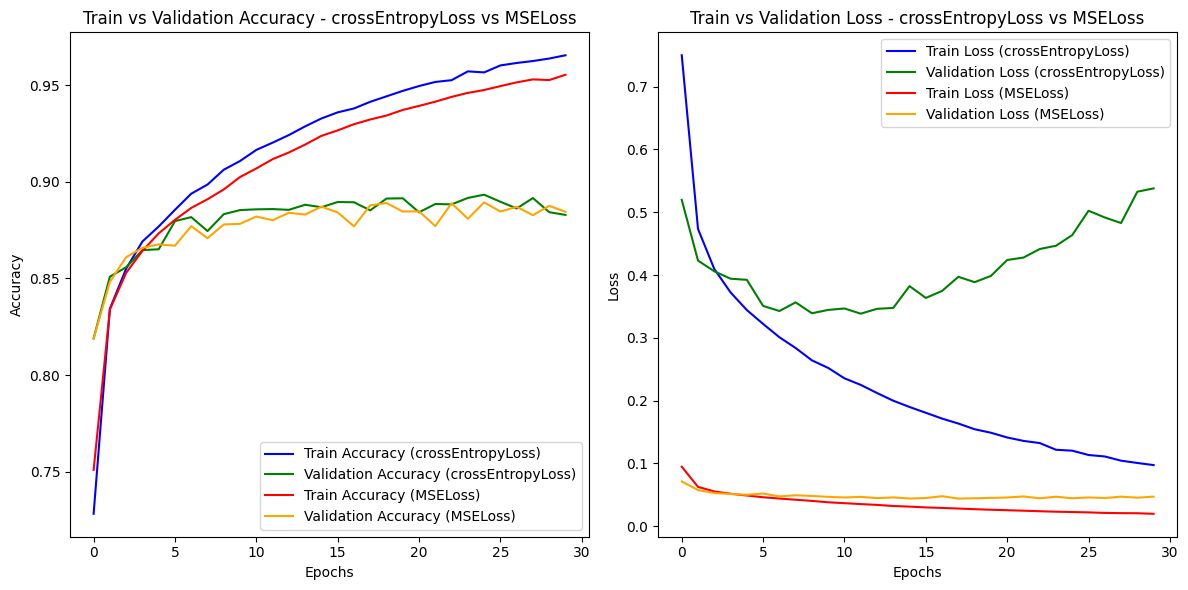

In [ ]:
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy (crossEntropyLoss)', color='b')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy (crossEntropyLoss)', color='g')
plt.plot(epochs_range, train_accuracies_2, label='Train Accuracy (MSELoss)', color='r')
plt.plot(epochs_range, val_accuracies_2, label='Validation Accuracy (MSELoss)', color='orange')
plt.title('Train vs Validation Accuracy - crossEntropyLoss vs MSELoss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss (crossEntropyLoss)', color='b')
plt.plot(epochs_range, val_losses, label='Validation Loss (crossEntropyLoss)', color='g')
plt.plot(epochs_range, train_losses_2, label='Train Loss (MSELoss)', color='r')
plt.plot(epochs_range, val_losses_2, label='Validation Loss (MSELoss)', color='orange')
plt.title('Train vs Validation Loss - crossEntropyLoss vs MSELoss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

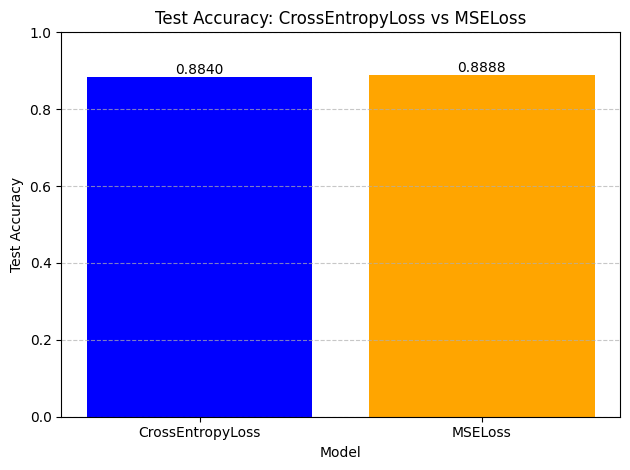

In [ ]:
import matplotlib.pyplot as plt

metrics = ['CrossEntropyLoss', 'MSELoss']
accuracy_values = [test_accuracy, test_accuracy_2]

plt.bar(metrics, accuracy_values, color=['blue', 'orange'])
for i, value in enumerate(accuracy_values):
    plt.annotate(f'{value:.4f}', (i, value), ha='center', va='bottom', fontsize=10)

plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy: CrossEntropyLoss vs MSELoss')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# **Improved / Best Model**

In [ ]:
# Improved CNN Model
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

improved_model = ImprovedCNNModel().to(device)
summary(improved_model, input_size=(32, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedCNNModel                         [32, 4]                   --
├─Conv2d: 1-1                            [32, 32, 28, 28]          320
├─BatchNorm2d: 1-2                       [32, 32, 28, 28]          64
├─MaxPool2d: 1-3                         [32, 32, 14, 14]          --
├─Conv2d: 1-4                            [32, 64, 14, 14]          18,496
├─BatchNorm2d: 1-5                       [32, 64, 14, 14]          128
├─MaxPool2d: 1-6                         [32, 64, 7, 7]            --
├─Linear: 1-7                            [32, 128]                 401,536
├─Dropout: 1-8                           [32, 128]                 --
├─Linear: 1-9                            [32, 64]                  8,256
├─Dropout: 1-10                          [32, 64]                  --
├─Linear: 1-11                           [32, 4]                   260
Total params: 429,060
Trainable params: 429,060
Non-trainable params: 

In [ ]:
# Improved model training with early stopping, LR scheduler, and gradient accumulation
loss_function_Improved = nn.CrossEntropyLoss()
optimizer_improved = optim.Adam(improved_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer_improved, mode='min', patience=3, factor=0.1, verbose=True)
early_stopping_patience = 5
best_val_loss = float('inf')
stopping_counter = 0
accumulation_steps = 4

train_losses_improved = []
val_losses_improved = []
train_accuracies_improved = []
val_accuracies_improved = []

improved_model.train()
start_time1 = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    correct, total = 0, 0
    optimizer_improved.zero_grad()

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.view(inputs.size(0), 1, 28, 28).to(device)
        labels = torch.argmax(labels, dim=1).to(device)
        outputs = improved_model(inputs)
        loss = loss_function_Improved(outputs, labels) / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer_improved.step()
            optimizer_improved.zero_grad()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_accuracies_improved.append(train_accuracy)
    train_losses_improved.append(running_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    improved_model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.view(val_inputs.size(0), 1, 28, 28).to(device)
            val_labels = torch.argmax(val_labels, dim=1).to(device)
            val_outputs = improved_model(val_inputs)
            loss = loss_function_Improved(val_outputs, val_labels)
            val_loss += loss.item()
            _, preds = torch.max(val_outputs, 1)
            correct += (preds == val_labels).sum().item()
            total += val_labels.size(0)

    val_accuracy = correct / total
    val_accuracies_improved.append(val_accuracy)
    val_losses_improved.append(val_loss / len(val_loader))
    print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        stopping_counter = 0
    else:
        stopping_counter += 1
    if stopping_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# Measure total training time
end_time1 = time.time()
training_time_Improved = end_time1 - start_time1
print(f"Training completed in Improved: {training_time_Improved:.2f} seconds")

Epoch [1/30], Train Loss: 0.1803, Train Accuracy: 0.7424
Val Loss: 0.5141, Val Accuracy: 0.8189
Epoch [2/30], Train Loss: 0.1151, Train Accuracy: 0.8385
Val Loss: 0.4109, Val Accuracy: 0.8590
Epoch [3/30], Train Loss: 0.0975, Train Accuracy: 0.8629
Val Loss: 0.3692, Val Accuracy: 0.8738
Epoch [4/30], Train Loss: 0.0871, Train Accuracy: 0.8758
Val Loss: 0.3573, Val Accuracy: 0.8761
Epoch [5/30], Train Loss: 0.0801, Train Accuracy: 0.8865
Val Loss: 0.3404, Val Accuracy: 0.8816
Epoch [6/30], Train Loss: 0.0735, Train Accuracy: 0.8959
Val Loss: 0.3388, Val Accuracy: 0.8832
Epoch [7/30], Train Loss: 0.0682, Train Accuracy: 0.9044
Val Loss: 0.3108, Val Accuracy: 0.8919
Epoch [8/30], Train Loss: 0.0639, Train Accuracy: 0.9111
Val Loss: 0.3248, Val Accuracy: 0.8933
Epoch [9/30], Train Loss: 0.0604, Train Accuracy: 0.9149
Val Loss: 0.3202, Val Accuracy: 0.8959
Epoch [10/30], Train Loss: 0.0562, Train Accuracy: 0.9220
Val Loss: 0.3054, Val Accuracy: 0.8975
Epoch [11/30], Train Loss: 0.0520, Trai

In [ ]:
# Save the model's weights
torch.save(improved_model.state_dict(), "best_model.pth")

In [ ]:
improved_model.eval()

test_preds_Improved = []
test_labels_list_improved = []

with torch.no_grad():
    for test_inputs, test_labels_batch in test_loader:
        test_inputs = test_inputs.view(test_inputs.size(0), 1, 28, 28).to(device)  # ✔️ Reshape input

        test_outputs = improved_model(test_inputs)
        _, preds = torch.max(test_outputs, 1)
        test_preds_Improved.extend(preds.cpu().numpy())

        if len(test_labels_batch.shape) > 1:
            test_labels_batch = test_labels_batch.argmax(dim=1)

        test_labels_list_improved.extend(test_labels_batch.cpu().numpy())

test_accuracy_improved = accuracy_score(test_labels_list_improved, test_preds_Improved)
test_precision_improved, test_recall_improved, test_f1_improved, _ = precision_recall_fscore_support(test_labels_list_improved, test_preds_Improved, average='macro')

print(f"Improved Model or Best Model")
print(f"Test Accuracy: {test_accuracy_improved:.4f}")
print(f"Test Precision: {test_precision_improved:.4f}, Test Recall: {test_recall_improved:.4f}, Test F1-Score: {test_f1_improved:.4f}")

Improved Model or Best Model
Test Accuracy: 0.9041
Test Precision: 0.8384, Test Recall: 0.8162, Test F1-Score: 0.8261


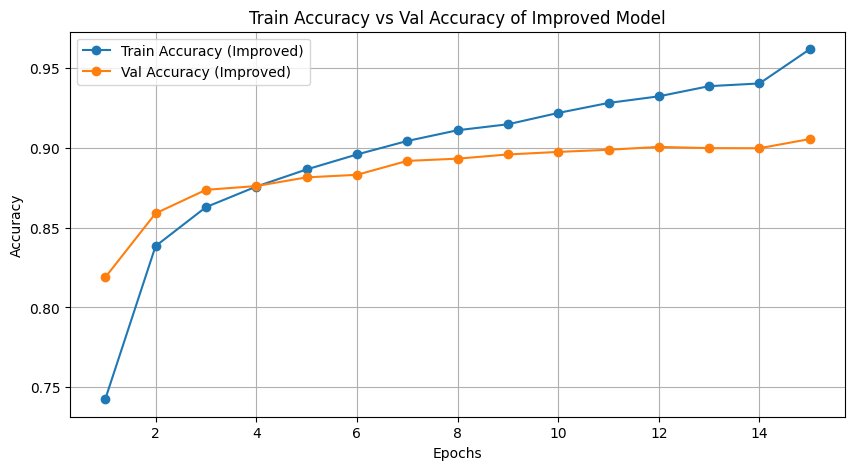

Base Model Training Time: 185.69 seconds
Improved Model Training Time: 91.42 seconds


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies_improved) + 1), train_accuracies_improved, label='Train Accuracy (Improved)', marker='o')
plt.plot(range(1, len(val_accuracies_improved) + 1), val_accuracies_improved, label='Val Accuracy (Improved)', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Val Accuracy of Improved Model')
plt.legend()
plt.grid(True)
plt.show()

print(f"Base Model Training Time: {training_time:.2f} seconds")
print(f"Improved Model Training Time: {training_time_Improved:.2f} seconds")

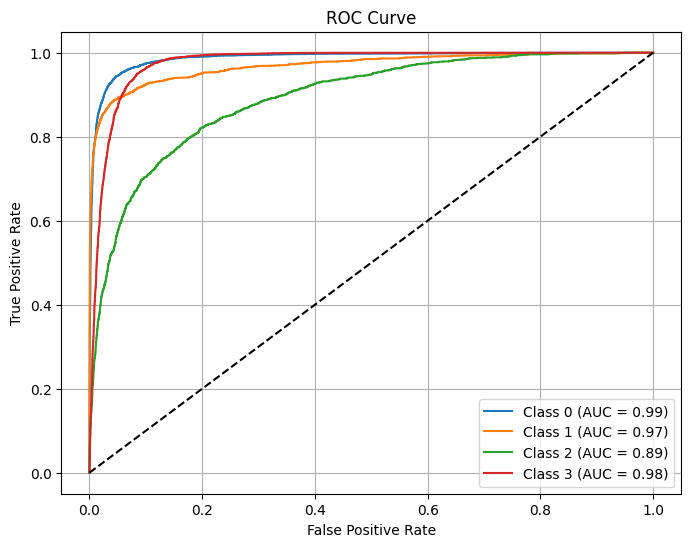

In [ ]:
# ROC Curve
test_outputs_list = []

with torch.no_grad():
    for test_inputs, _ in test_loader:
        test_inputs = test_inputs.view(test_inputs.size(0), 1, 28, 28).to(device)
        test_outputs = model(test_inputs)
        test_outputs_list.extend(test_outputs.cpu().numpy())

test_outputs_array = np.array(test_outputs_list)

test_labels_one_hot = F.one_hot(torch.tensor(test_labels_list), num_classes=4).numpy()
test_preds_probs = F.softmax(torch.tensor(test_outputs_array), dim=1).numpy()

plt.figure(figsize=(8, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(test_labels_one_hot[:, i], test_preds_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# **Comparision Base Model vs Improved/Best Model**

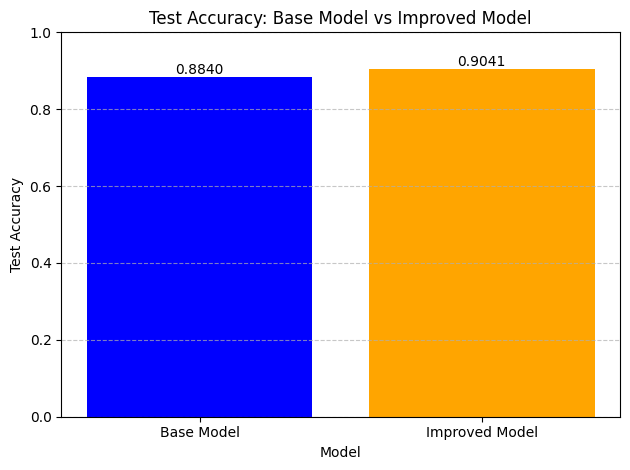

In [ ]:
metrics = ['Base Model', 'Improved Model']
accuracy_values = [test_accuracy, test_accuracy_improved]

plt.bar(metrics, accuracy_values, color=['blue', 'orange'])
for i, value in enumerate(accuracy_values):
    plt.annotate(f'{value:.4f}', (i, value), ha='center', va='bottom', fontsize=10)

plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy: Base Model vs Improved Model')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


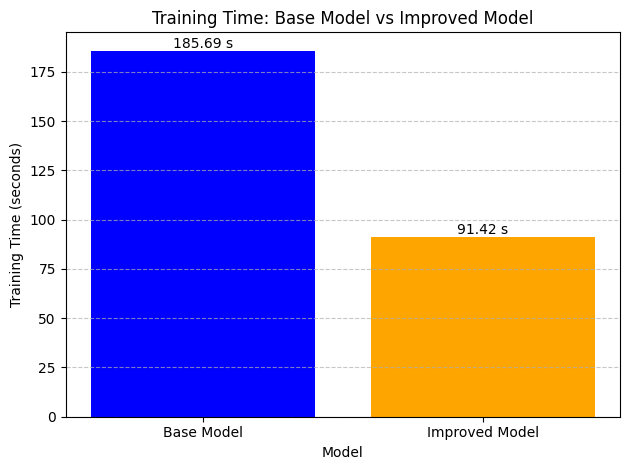

In [ ]:
metrics = ['Base Model', 'Improved Model']
time_values = [training_time, training_time_Improved]

plt.bar(metrics, time_values, color=['blue', 'orange'])
for i, value in enumerate(time_values):
    plt.annotate(f'{value:.2f} s', (i, value), ha='center', va='bottom', fontsize=10)

plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time: Base Model vs Improved Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


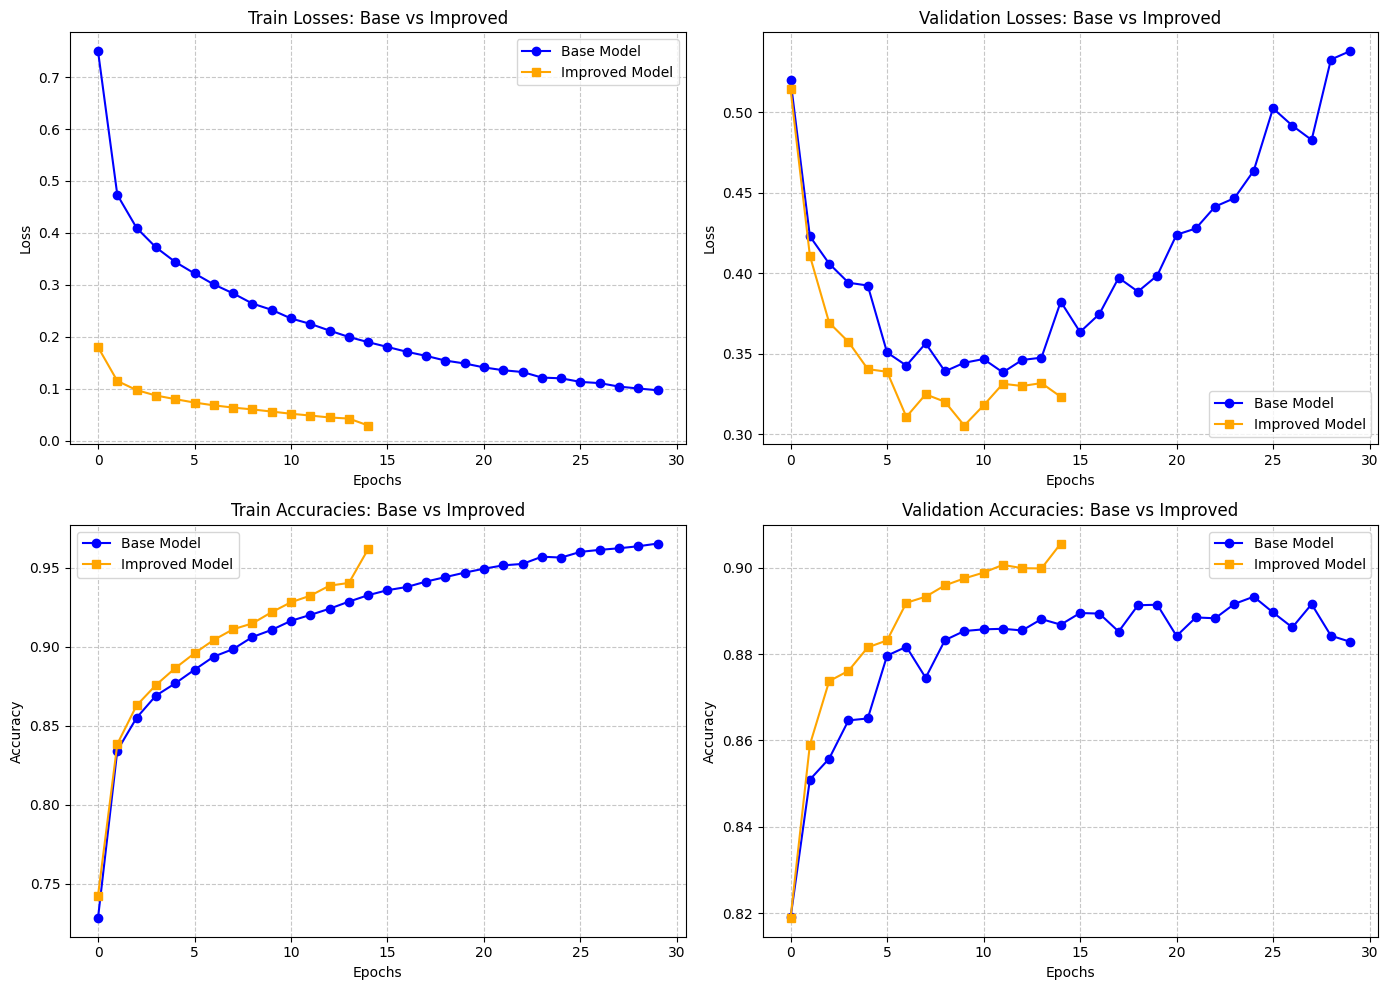

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Train Losses
axs[0, 0].plot(train_losses, label='Base Model', color='blue', marker='o')
axs[0, 0].plot(train_losses_improved, label='Improved Model', color='orange', marker='s')
axs[0, 0].set_title('Train Losses: Base vs Improved')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(linestyle='--', alpha=0.7)

# Validation Losses
axs[0, 1].plot(val_losses, label='Base Model', color='blue', marker='o')
axs[0, 1].plot(val_losses_improved, label='Improved Model', color='orange', marker='s')
axs[0, 1].set_title('Validation Losses: Base vs Improved')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(linestyle='--', alpha=0.7)

# Train Accuracies
axs[1, 0].plot(train_accuracies, label='Base Model', color='blue', marker='o')
axs[1, 0].plot(train_accuracies_improved, label='Improved Model', color='orange', marker='s')
axs[1, 0].set_title('Train Accuracies: Base vs Improved')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(linestyle='--', alpha=0.7)

# Validation Accuracies
axs[1, 1].plot(val_accuracies, label='Base Model', color='blue', marker='o')
axs[1, 1].plot(val_accuracies_improved, label='Improved Model', color='orange', marker='s')
axs[1, 1].set_title('Validation Accuracies: Base vs Improved')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# from google.colab import files
# files.download("best_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reference Used:
1. https://pytorch.org/tutorials/beginner/introyt/introyt_index.html
2. https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html
3. https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html
4. https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html
5. https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html
6. https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html
7. https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
8. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html
9. https://builtin.com/articles/1-5-iqr-rule
10. https://builtin.com/data-science/correlation-matrix
11. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
12. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
13. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html
14. https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html
15. https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
16. https://medium.com/@sahin.samia/understanding-r-squared-in-regression-analysis-2d8246a63dbb
17. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
18. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html